## Race Predictions ##
### An exploration of data forcasting techniques so I don't forgot how data works in python ###

In [49]:
import requests
import pandas as pd

#### Load Data ####

For the data, I will be using the  'jolpi.ca F1 API' which can be found [here](https://api.jolpi.ca/ergast/).

At first I played around with the idea of loading and structuing all the data myself, although this was far less performant and would require the split into testing and training data manually,
So instead I will be using Pandas.

In [50]:
# Output data in python dictionary
# # Get the bulk of the data as a python object
# race_years = ['2024', '2023', '2022']
# races = {}
# for year in race_years:
#     races[year] = {}

# # Pandas can just do this all automatically but good to know how it roughly works :)
# for year in race_years:
    
#     request_limiter = 0
#     results = requests.get("http://api.jolpi.ca/ergast/f1/"+year+"/results?limit=100").json()["MRData"]
#     for result in results["RaceTable"]["Races"]:
#         races[year][result["raceName"]] = result["Results"]

#     while(int(results["total"]) > request_limiter + 100):
#         request_limiter += 100
#         results = requests.get("http://api.jolpi.ca/ergast/f1/"+year+"/results?limit=100&offset="+str(request_limiter)).json()["MRData"]
#         for result in results["RaceTable"]["Races"]:  
#             races[year][result["raceName"]] = result["Results"]


In [51]:
# Output data in pandas dataframe
base_url = "http://api.jolpi.ca/ergast/f1/2024/results"
limit = 100
offset = 0

response = requests.get(f"{base_url}?limit={1}&offset={offset}").json()
total_results = int(response["MRData"]["total"])
race_dataframes = {}

while offset < total_results:
    response = requests.get(f"{base_url}?limit={limit}&offset={offset}").json()
    results = response["MRData"]["RaceTable"]["Races"]

    for race in results:
        race_name = race["raceName"] 
        if race_name not in race_dataframes:
            race_dataframes[race_name] = []

        for res in race["Results"]:
            race_dataframes[race_name].append({
                "DriverCode": res["Driver"]["code"],
                "ConstructorId": res["Constructor"]["constructorId"],
                "StartingPosition": int(res["grid"]),
                "RaceResult": int(res["position"]),
                "PositionsGained": int(res["grid"]) - int(res["position"])
            })
    offset += limit

for race_name in race_dataframes:
    race_dataframes[race_name] = pd.DataFrame(race_dataframes[race_name])


for race_name, df in race_dataframes.items():
    print(f"Results for {race_name}:")
    print(df)


Results for Bahrain Grand Prix:
   DriverCode ConstructorId  StartingPosition  RaceResult  PositionsGained
0         VER      red_bull                 1           1                0
1         PER      red_bull                 5           2                3
2         SAI       ferrari                 4           3                1
3         LEC       ferrari                 2           4               -2
4         RUS      mercedes                 3           5               -2
5         NOR       mclaren                 7           6                1
6         HAM      mercedes                 9           7                2
7         PIA       mclaren                 8           8                0
8         ALO  aston_martin                 6           9               -3
9         STR  aston_martin                12          10                2
10        ZHO        sauber                17          11                6
11        MAG          haas                15          12           

#### Basic Data Visualisation ####

Just to get a bit of a look at the data before we try some forcasting

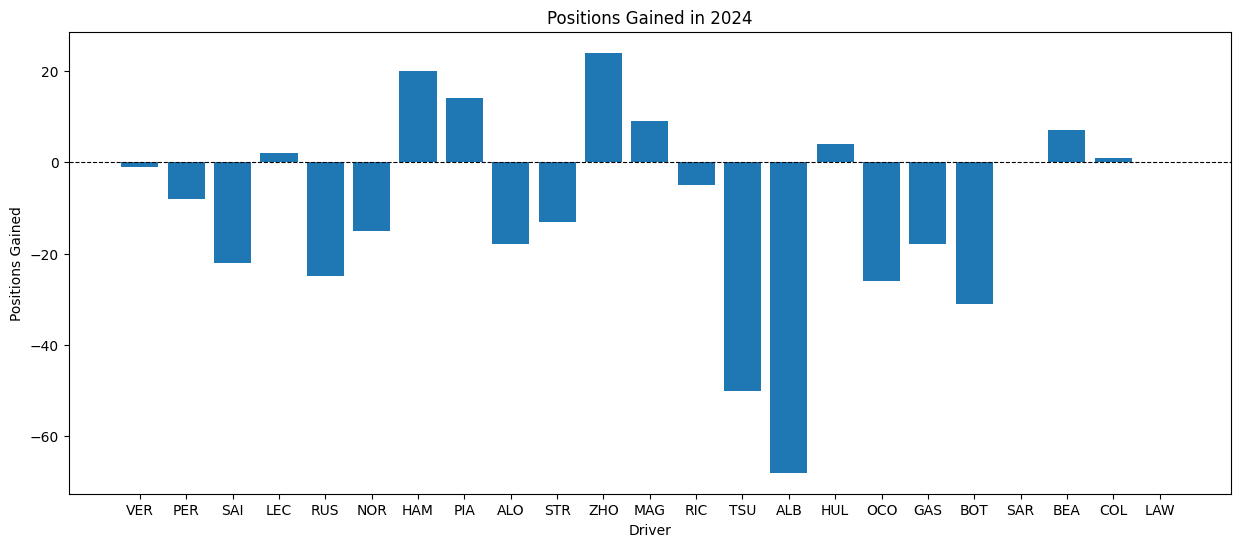

In [52]:
import matplotlib.pyplot as plt

# Total positions gained over the season
# Obviously insanely flawed because it doesn't take into account starting positions and includes anomaly like DNF
position_gained = {}

for race_name, df in race_dataframes.items():
    for _, row in df.iterrows(): 
        driver_code = row["DriverCode"]
        positions_gained = row["PositionsGained"]
        
        if driver_code not in position_gained:
            position_gained[driver_code] = 0
        position_gained[driver_code] += positions_gained

positions_gained_df = pd.DataFrame(list(position_gained.items()), columns=["DriverCode", "PositionsGained"])

plt.figure(figsize=(15, 6))
plt.bar(positions_gained_df['DriverCode'], positions_gained_df['PositionsGained'])
plt.title(f'Positions Gained in 2024')
plt.xlabel('Driver')
plt.ylabel('Positions Gained')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

**Why does this look so negative?**

In terms of starting positions, there is not a number grid position for drivers who start in the pits, and the API returns it as 0. If the driver starts in position 0 then any result, even a 1st place, will be considered a negative result which hugely scew the results.

In order to fix this, we can just manually replace all these 0 values in the starting position with a heuristic calculated starting position. But what if there are multiple starting in the pits? Well there isn't really a way to know, so for now we will just assign this at random.

In [56]:
for race_name, df in race_dataframes.items():
    for index, row in df.iterrows(): 
        starting_pos = row["StartingPosition"]
        if starting_pos == 0:
            df.loc[index, "StartingPosition"] = df["StartingPosition"].max() + 1
    df["PositionsGained"] = df.apply(
        lambda row: int(row["StartingPosition"]) - int(row["RaceResult"]),
        axis=1
    )
for race_name, df in race_dataframes.items():
    print(f"Results for {race_name}:")
    print(df)

Results for Bahrain Grand Prix:
   DriverCode ConstructorId  StartingPosition  RaceResult  PositionsGained
0         VER      red_bull                 1           1                0
1         PER      red_bull                 5           2                3
2         SAI       ferrari                 4           3                1
3         LEC       ferrari                 2           4               -2
4         RUS      mercedes                 3           5               -2
5         NOR       mclaren                 7           6                1
6         HAM      mercedes                 9           7                2
7         PIA       mclaren                 8           8                0
8         ALO  aston_martin                 6           9               -3
9         STR  aston_martin                12          10                2
10        ZHO        sauber                17          11                6
11        MAG          haas                15          12           

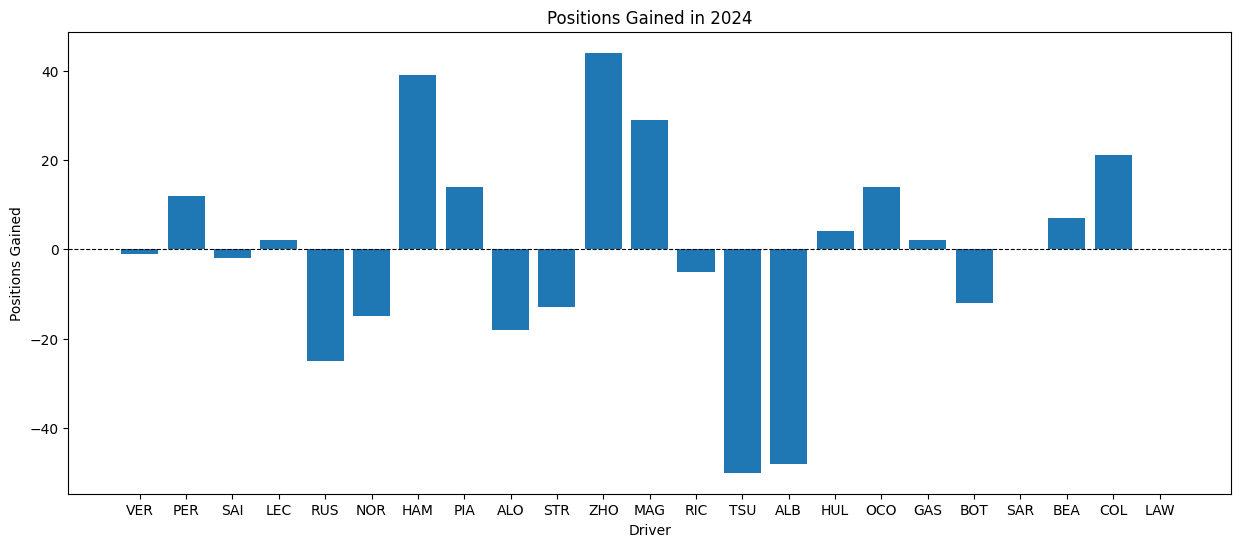

In [57]:
position_gained = {}

for race_name, df in race_dataframes.items():
    for _, row in df.iterrows(): 
        driver_code = row["DriverCode"]
        positions_gained = row["PositionsGained"]
        
        if driver_code not in position_gained:
            position_gained[driver_code] = 0
        position_gained[driver_code] += positions_gained

positions_gained_df = pd.DataFrame(list(position_gained.items()), columns=["DriverCode", "PositionsGained"])

plt.figure(figsize=(15, 6))
plt.bar(positions_gained_df['DriverCode'], positions_gained_df['PositionsGained'])
plt.title(f'Positions Gained in 2024')
plt.xlabel('Driver')
plt.ylabel('Positions Gained')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()